__(a)__ Train a convolutional neural network on the data. Find a good set of hyperparameters for the model. Do you think a convolutional neural network is suitable for this kind of problem? Why/why not?

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import numpy as np
from numpy.random import seed, randint

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
#Those 2 lines are used by Yoana as she is running this in docker
X = np.load('/project/XSound.npy')
Y = tf.keras.utils.to_categorical(np.load('/project/YSound.npy'))

#X = np.load('XSound.npy')
#Y = tf.keras.utils.to_categorical(np.load('YSound.npy'))

print(X.shape)
print(Y.shape)
print(Y)

(15737, 62, 65, 1)
(15737, 4)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [3]:
X_, X_test, Y_, Y_test = train_test_split(X, Y, train_size=.8, random_state=504)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, train_size=.75, random_state=504)

In [4]:
print(X_train[0].shape)

(62, 65, 1)


In [5]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)

cnn = tf.keras.models.Sequential([
    layers.Conv2D(240, 3, activation='relu', padding='same', input_shape=X_train[0].shape),
    layers.MaxPooling2D((3)),
    layers.SpatialDropout2D(.4),
    layers.AveragePooling2D(),
    layers.Conv2D(120, 3, activation='relu', padding='same'),
    layers.SpatialDropout2D(.4),
    layers.AveragePooling2D(),
    #layers.Conv2D(16, 3, activation='relu', padding='same'),
    #layers.SpatialDropout2D(.4),
    layers.Flatten(),
    layers.Dense(units=150, activation='relu'),
    layers.Dropout(.4),
    layers.Dense(units=4, activation='softmax')
])

cnn.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001), metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 65, 240)       2400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 21, 240)       0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 20, 21, 240)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 10, 10, 240)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 120)       259320    
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 10, 10, 120)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 120)         0

In [6]:
history = cnn.fit(X_train, Y_train, 
                    epochs = 100, 
                    validation_data=(X_valid, Y_valid),
                    callbacks=[es])

Train on 9441 samples, validate on 3148 samples
Epoch 1/100
9441/9441 [==============================] - 674s 71ms/sample - loss: 1.4743 - accuracy: 0.2432 - val_loss: 1.4389 - val_accuracy: 0.2519
Epoch 2/100
9441/9441 [==============================] - 3s 295us/sample - loss: 1.3865 - accuracy: 0.2507 - val_loss: 1.4389 - val_accuracy: 0.2522
Epoch 3/100
9441/9441 [==============================] - 3s 286us/sample - loss: 1.3865 - accuracy: 0.2455 - val_loss: 1.4393 - val_accuracy: 0.2522
Epoch 4/100
9441/9441 [==============================] - 3s 293us/sample - loss: 1.3863 - accuracy: 0.2620 - val_loss: 1.4391 - val_accuracy: 0.2598
Epoch 5/100
9441/9441 [==============================] - 3s 288us/sample - loss: 1.3864 - accuracy: 0.2527 - val_loss: 1.4396 - val_accuracy: 0.2579
Epoch 6/100
9441/9441 [==============================] - 3s 286us/sample - loss: 1.3864 - accuracy: 0.2512 - val_loss: 1.4400 - val_accuracy: 0.2541
Epoch 7/100
9441/9441 [==============================] - 

In [7]:
train_eval = cnn.evaluate(X_train[:9441], Y_train[:9441])
test_eval = cnn.evaluate(X_test, Y_test)
print("On train data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=train_eval[0], accuracy=train_eval[1]))
print("On test data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=test_eval[0], accuracy=test_eval[1]))
print("Error on test data: {p:.2f}%".format(p = 100*(1-test_eval[1])))

3148/3148 [==============================] - 0s 99us/sample - loss: 1.4220 - accuracy: 0.2449
On train data: Loss = 1.4289, accuracy = 0.2443
On test data: Loss = 1.4220, accuracy = 0.2449
Error on test data: 75.51%


__(b)__ Classify instances of the test set using your models. Draw a confusion matrix and comment on the results.

(3148, 4)
(3148, 4)


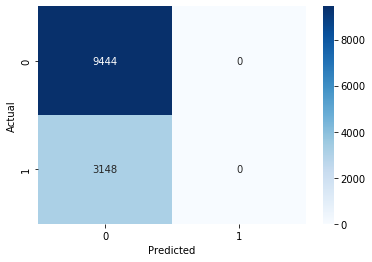

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions = cnn.predict(X_test)
print(predictions.shape)
print(Y_test.shape)

mat = tf.math.confusion_matrix(
    Y_test.flatten(),
    predictions.flatten(),
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

sns.heatmap(mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
print("Confusion matrix:  \n{}\n".format(tf.math.confusion_matrix(
    Y_test.flatten(),
    predictions.flatten(),
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)))

TP = tf.math.count_nonzero(predictions.flatten() * Y_test.flatten())
TN = tf.math.count_nonzero((predictions.flatten() - 1) * (Y_test.flatten() - 1))
FP = tf.math.count_nonzero(predictions.flatten() * (Y_test.flatten() - 1))
FN = tf.math.count_nonzero((predictions.flatten() - 1) * Y_test.flatten())

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FN + TN + FP)

print("Accuracy: \n{}\n".format(accuracy))
print("Precision: \n{}\n".format(precision))
print("Recall: \n{}\n".format(recall))
print("F1: \n{}".format(f1))

Confusion matrix:  
[[9444    0]
 [3148    0]]

Accuracy: 
0.5

Precision: 
0.25

Recall: 
0.5

F1: 
0.3333333333333333


__(c)__ Choose one other algorithm from the course, and redo (a) and (b) using this algorithm. Supply a brief discussion of why we would expect this algorithm to do better/worse than the CNN.

In [25]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline 
import numpy as np
from sklearn.model_selection import train_test_split

#Those 2 lines are used by Yoana as she is running this in docker
X = np.load('/project/XSound.npy')
Y = np.load('/project/YSound.npy')

#X = np.load('XSound.npy')
#Y = tf.keras.utils.to_categorical(np.load('YSound.npy'))

X_df = pd.DataFrame(X.reshape(-1, 4030))
Y_df = pd.DataFrame(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, train_size=.8, random_state=0)

# Create a pipeline with StandardScaler and RidgeCV
alphas = 10**np.linspace(10,-2,100)*0.5
ridgecv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error'))
ridgecv.fit(X_train, Y_train)

# Access the chosen alpha value from RidgeCV
chosen_alpha = ridgecv.named_steps['ridgecv'].alpha_
print(chosen_alpha)

# # Create a Ridge model using the chosen alpha from RidgeCV
ridge_model = Ridge(alpha=ridgecv.named_steps['ridgecv'].alpha_)
ridge_model.fit(X_train, Y_train)


53613.36110051616


Ridge(alpha=53613.36110051616)

R^2 on train data is 0.3162739711287469 and on test data is 0.30584181453612036
[[-1.9896817e-03  1.6974082e-04 -3.1041057e-04 ...  2.8298073e-05
   7.0328970e-05 -2.3081271e-05]]
0.8835193682117054
[-1.96896    -1.239222   -0.91658115 ...  5.091192    6.12128
  6.3066916 ]
[0 1 2 3]


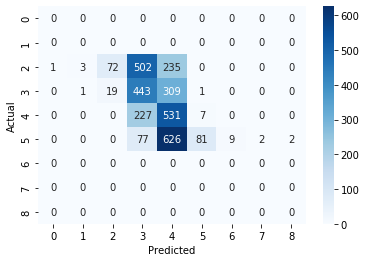

In [41]:
from sklearn.metrics import  confusion_matrix

#Show R^2
print("R^2 on train data is {} and on test data is {}".format(ridge_model.score(X_train, Y_train), 
                                                              ridge_model.score(X_test,Y_test)))
print(ridge_model.coef_)
# Calculate the test MSE using the trained Ridge model
predictions = ridge_model.predict(X_test)
mse = mean_squared_error(Y_test, predictions)
print(mse)   
#ridge_model.fit(X_df, Y_df)
predictions_asint = np.rint(predictions).astype(int)
predictions_df = pd.DataFrame(predictions_asint)

#Create confusion matrix
mat = confusion_matrix(Y_test, predictions_df)

sns.heatmap(mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()